In [ ]:
import tarfile

# Extract 'train-clean-100.tar.gz'
with tarfile.open('/scratchSSD2/databaseTFM/train-clean-100.tar.gz', 'r:gz') as tar:
    tar.extractall('/scratchSSD2/databaseTFM/LibriSpeech/dev-clean')

Functions for adding noise and segmenting

In [2]:
import librosa
import numpy as np
import os
import math

SAMPLE_RATE = 16000

def add_noise(audio) : 
    P_signal = audio.std()**2    # Power of the signal
    SNR_dB = np.random.uniform(5,15)
    P_noise = P_signal * 10**(-SNR_dB / 10)
    noise = np.sqrt(P_noise) * np.random.randn(len(audio))

    n_audio = audio + noise

    n_audio = np.clip(n_audio, -2**15, 2**15 - 1)  # for 16-bit PCM audio

    
    return n_audio  


def split_or_pad_audio(file_path, segment_duration=5000):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Calculate the number of 5-second segments
    samples_duration = int((segment_duration/1000)*SAMPLE_RATE)
    num_segments = math.ceil(len(audio)/samples_duration)
    
    segments = []
    for i in range(num_segments):
        start = i * samples_duration
        end = start + samples_duration
        segment = audio[start:end]
        
        if len(segment) < samples_duration:
            padding = np.zeros(samples_duration - len(segment))
            segment = np.concatenate([segment, padding])
            
        segments.append((add_noise(segment),segment))

    return segments

In [3]:
# Spliting Audios 5 seconds

import pickle
import os

# Gather audio file paths and transcriptions
audio_tuple = []
count = 0
max_files = 5000

for root, dirs1, files in os.walk("/scratchSSD2/databaseTFM/LibriSpeech/dev-clean"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            segment_tuple = split_or_pad_audio(audio_path,5000)
            audio_tuple.extend(segment_tuple)
            count += 1
            if count >= max_files:
                break
    if count >= max_files:
        break


# Save the tuple to a file
output_file = "/scratchSSD2/databaseTFM/audio_tuple_5k_5dB.pkl"
with open(output_file, "wb") as f:
    pickle.dump(audio_tuple, f)
    print(f"Saved {len(audio_tuple)} audio segments to {output_file}")



Saved 15364 audio segments to /scratchSSD2/databaseTFM/audio_tuple_5k_5dB.pkl


In [ ]:
import soundfile as sf

sf.write("naudio1.wav", audio_tuple[0][0], SAMPLE_RATE)
sf.write("caudio1.wav", audio_tuple[0][1], SAMPLE_RATE)

In [ ]:
import pickle
output_file = "/scratchSSD2/databaseTFM/audio_tuple_5k_5dB.pkl"
with open(output_file, "rb") as f:
    audio_tuple = pickle.load(f)
    print(f"Loaded {len(audio_tuple)} audio segments from {output_file}")

Loaded 15364 audio segments from /scratchSSD2/databaseTFM/audio_tuple_5k.pkl


In [5]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_data):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.audio_data = audio_data  

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        
        noisy_audio, clean_audio = self.audio_data[idx]
        # Load audio and calculate spectrogram from clean and noisy audio
        S_noisy = librosa.stft(noisy_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        S_clean = librosa.stft(clean_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean

In [6]:
from torch.utils.data import DataLoader

audio_dataset = AudioDataset(audio_tuple)
audio_dataloader = DataLoader(audio_dataset, batch_size=32, shuffle=True)
print(len(audio_dataloader))

481


tensor([[-42.0571, -38.8413, -43.2477,  ..., -51.1980, -32.9106, -26.2363],
        [-38.5665, -31.4315, -44.0876,  ..., -34.7807, -28.9206, -27.3695],
        [-35.0994, -27.0962, -31.5248,  ..., -29.5597, -28.6803, -31.2070],
        ...,
        [-42.0427, -41.0664, -44.7945,  ..., -43.7453, -40.6812, -42.9897],
        [-46.4256, -39.7704, -44.3961,  ..., -41.0075, -42.4492, -47.3835],
        [-65.7169, -39.8756, -45.2250,  ..., -37.5725, -60.8422, -52.4612]])
tensor([[-42.1464, -36.3782, -44.8974,  ..., -77.2629, -34.7307, -26.9081],
        [-40.4268, -31.3993, -34.9367,  ..., -33.1942, -28.7521, -28.1041],
        [-38.0029, -28.0213, -29.9344,  ..., -28.3860, -27.8077, -31.8003],
        ...,
        [-68.5497, -66.8241, -76.2598,  ..., -45.1071, -60.1342, -57.5642],
        [-69.2964, -63.8211, -73.0298,  ..., -49.3341, -56.4440, -61.7777],
        [-72.1134, -63.3104, -67.0797,  ..., -58.7293, -51.1138, -75.5487]])


Text(0.5, 1.0, 'Clean Spectrogram')

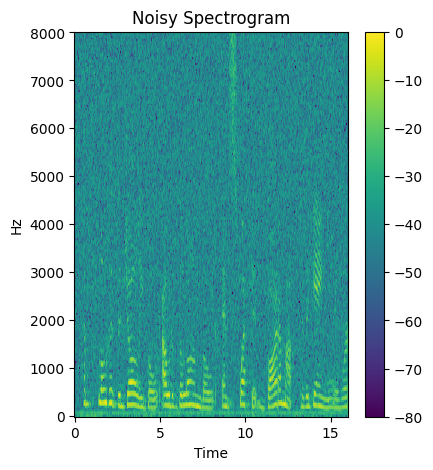

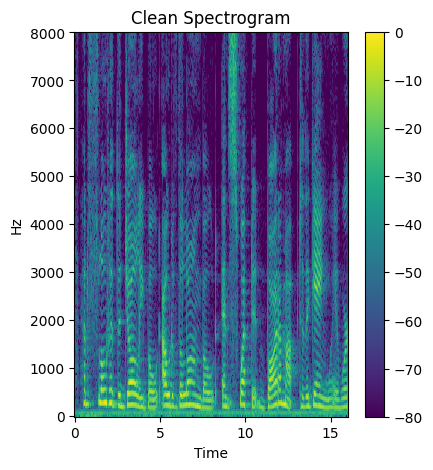

In [13]:
import librosa.display
import matplotlib.pyplot as plt
print(audio_dataset[0][0])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(audio_dataset[0][0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
plt.colorbar()
plt.title("Noisy Spectrogram")

print(audio_dataset[0][1])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(audio_dataset[0][1].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
plt.colorbar()
plt.title("Clean Spectrogram")

Training


LSTM NET

In [8]:
class Net1(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size, bidir=False, n_lstm_layers=1):
    super().__init__()
    self.linear1 = torch.nn.Linear(input_size, 2*input_size)
    self.LSTM = torch.nn.LSTM(2*input_size, hidden_size, batch_first=True, bidirectional=bidir, num_layers=n_lstm_layers)
    self.drop = torch.nn.Dropout(0.1)
    self.linear2 = torch.nn.Linear(2*hidden_size, output_size)
  def forward(self, x):
    x = self.linear1(x)
    x, _ = self.LSTM(x)
    x = self.drop(x)
    x = self.linear2(x)
    return x

In [9]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    """
    Train the LSTM model.
    
    Args:
        model (nn.Module): The LSTM model to train.
        dataloader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
    """

    J = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    J_it = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        #model.train()  # Set the model to training model
        k = 0
        for noisy_audio, clean_audio in dataloader:
            
            noisy_audio = noisy_audio.transpose(1, 2).to(device)  # LSTM expects (batch, seq_len, input_size)
            clean_audio = clean_audio.transpose(1, 2).to(device)

            # Normalization
            noisy_audio = (noisy_audio - noisy_audio.mean()) / noisy_audio.std()
            clean_audio = (clean_audio - clean_audio.mean()) / clean_audio.std()
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(noisy_audio)
            
            # Compute the loss (MSE loss between predicted and clean spectrogram)
            loss = J(output, clean_audio)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            J_it[epoch] += loss.item()
            k += 1
        
        # Print the average loss for this epoch
        J_it[epoch] /= k
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {J_it[epoch]:.4f}")

    print("Training complete.")
    print(k)
    plt.clf()
    plt.plot(J_it,'b', markersize=8, linestyle='-', marker='.')
    plt.ylabel('J')
    plt.xlabel('it')
    plt.grid(True)


Using device: cuda
Epoch 1/40, Loss: 0.2437
Epoch 2/40, Loss: 0.1829
Epoch 3/40, Loss: 0.1645
Epoch 4/40, Loss: 0.1569
Epoch 5/40, Loss: 0.1445
Epoch 6/40, Loss: 0.1435
Epoch 7/40, Loss: 0.1723
Epoch 8/40, Loss: 0.1556
Epoch 9/40, Loss: 0.1353
Epoch 10/40, Loss: 0.1299
Epoch 11/40, Loss: 0.1270
Epoch 12/40, Loss: 0.1258
Epoch 13/40, Loss: 0.1204
Epoch 14/40, Loss: 0.1183
Epoch 15/40, Loss: 0.1166
Epoch 16/40, Loss: 0.1206
Epoch 17/40, Loss: 0.1138
Epoch 18/40, Loss: 0.1137
Epoch 19/40, Loss: 0.1105
Epoch 20/40, Loss: 0.1114
Epoch 21/40, Loss: 0.1112
Epoch 22/40, Loss: 0.1100
Epoch 23/40, Loss: 0.1153
Epoch 24/40, Loss: 0.1157
Epoch 25/40, Loss: 0.1079
Epoch 26/40, Loss: 0.1045
Epoch 27/40, Loss: 0.1035
Epoch 28/40, Loss: 0.1029
Epoch 29/40, Loss: 0.1028
Epoch 30/40, Loss: 0.1017
Epoch 31/40, Loss: 0.1014
Epoch 32/40, Loss: 0.1018
Epoch 33/40, Loss: 0.0990
Epoch 34/40, Loss: 0.0995
Epoch 35/40, Loss: 0.0985
Epoch 36/40, Loss: 0.0978
Epoch 37/40, Loss: 0.0998
Epoch 38/40, Loss: 0.1018
Ep

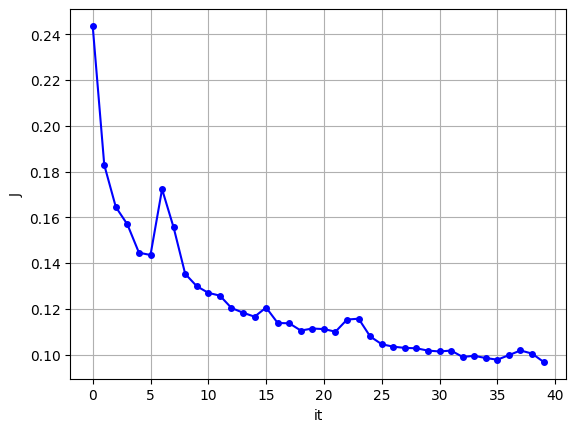

In [10]:
# Define model parameters
input_size = 257  # For example, number of frequency bins in STFT (assuming 512 FFT size, 257 bins for half)
hidden_size = 512  # Hidden layer size
output_size = 257  # Output has the same size as input spectrogram (257 bins)
num_epochs = 40
learning_rate = 0.001
bidir_lstm = True
num_lstm_layers = 3

#Selecting cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
model = Net1(input_size, hidden_size, output_size, bidir_lstm, num_lstm_layers)

# Train the model
train_model(model.to(device), audio_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

# Save weights of the model
torch.save(model.state_dict(), 'model_weights.pth')


In [11]:
# Save weights of the model
torch.save(model, 'model_weights.pth')

In [ ]:
# Model class must be defined somewhere
model = torch.load('model_weights.pth', weights_only=False)
model.eval()

TESTING PHASE

In [ ]:
!wget https://www.openslr.org/resources/12/test-clean.tar.gz -O /scratchSSD2/databaseTFM/test-clean.tar.gz

In [ ]:
import tarfile

# Extract 'test-clean-100.tar.gz'
with tarfile.open('/scratchSSD2/databaseTFM/test-clean.tar.gz', 'r:gz') as tar:
    tar.extractall('/scratchSSD2/databaseTFM/LibriSpeech/test-clean')

In [ ]:
# Spliting Audios 5 seconds

import math
import os

# Gather audio file paths and transcriptions
test_audio_tuple = []

for root, dirs1, files in os.walk("/scratchSSD2/databaseTFM/LibriSpeech/test-clean"):
    for file in files:
        if file.endswith(".flac"):
            test_audio_path = os.path.join(root, file)
            segment_tuple = split_or_pad_audio(audio_path,5000)
            test_audio_tuple.extend(segment_tuple)

# Save the tuple to a file
test_output_file = "/scratchSSD2/databaseTFM/test_audio_tuple.pkl"
with open(test_output_file, "wb") as f:
    pickle.dump(test_audio_tuple, f)
    print(f"Saved {len(test_audio_tuple)} audio segments to {test_output_file}")

Saved 7860 audio segments to /scratchSSD2/databaseTFM/test_audio_tuple.pkl


In [14]:
import pickle
test_output_file = "/scratchSSD2/databaseTFM/test_audio_tuple.pkl"
with open(test_output_file, "rb") as f:
    test_audio_tuple = pickle.load(f)
    print(f"Loaded {len(test_audio_tuple)} audio segments from {test_output_file}")

Loaded 7860 audio segments from /scratchSSD2/databaseTFM/test_audio_tuple.pkl


In [15]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader

# Select the first 10 samples
test_audio_dataset = AudioDataset(test_audio_tuple)
subset_indices = list(range(10))  # Indices for the first 10 samples
test_audio_subset = Subset(test_audio_dataset, subset_indices)

# Create the DataLoader
test_audio_dataloader = DataLoader(test_audio_subset, batch_size=1)

# Print the length of the DataLoader
print(len(test_audio_dataloader))  # Should print 10

10


tensor([[-32.5607, -30.7135, -26.4212,  ..., -26.7794, -37.8716, -29.3671],
        [-32.7155, -34.6719, -28.6714,  ..., -32.2730, -27.6767, -29.6978],
        [-33.3132, -35.6770, -30.8572,  ..., -31.6095, -25.6217, -30.8586],
        ...,
        [-44.7056, -33.3273, -30.1149,  ..., -40.4875, -36.1791, -34.1740],
        [-37.7387, -36.0122, -31.9493,  ..., -33.5157, -36.8864, -36.9209],
        [-36.0928, -30.8651, -35.4891,  ..., -31.6191, -37.8102, -37.5037]])


Text(0.5, 1.0, 'Noisy Spectrogram')

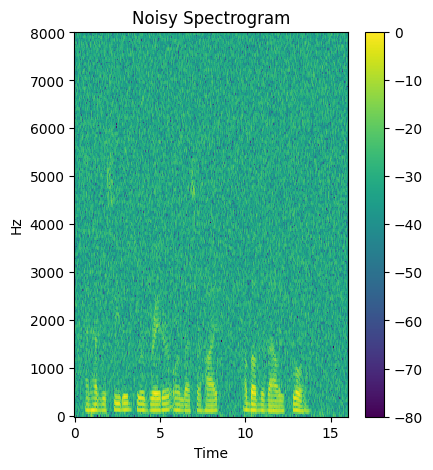

In [12]:
import librosa.display
import matplotlib.pyplot as plt
print(test_audio_dataset[0][0])
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(test_audio_dataset[0][0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
plt.colorbar()
plt.title("Noisy Spectrogram")

torch.Size([257, 501])
torch.Size([257, 501])


Text(0.5, 1.0, 'Precited Spectrogram')

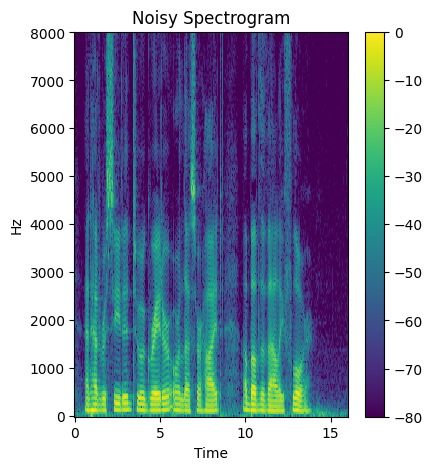

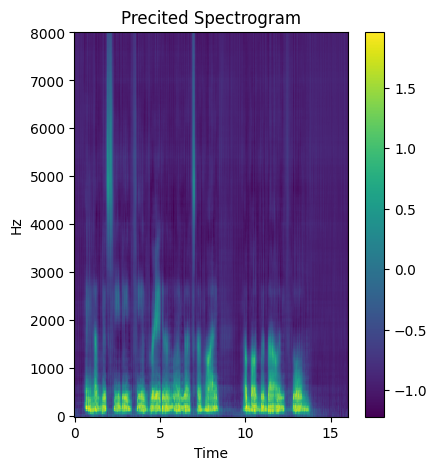

In [13]:
y = model(test_audio_dataset[0][0].transpose(0,1).cuda()).transpose(0,1)
print(y.shape)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(test_audio_dataset[0][1].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
plt.colorbar()
plt.title("Noisy Spectrogram")
print(y.shape)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
librosa.display.specshow(y.detach().cpu().numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
plt.colorbar()
plt.title("Precited Spectrogram")

In [16]:
import torch

def calculate_snr(clean_spectrogram, predicted_spectrogram):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels (dB).
    
    Args:
        clean_spectrogram (torch.Tensor): Clean spectrogram (desired signal).
        predicted_spectrogram (torch.Tensor): Predicted (or noisy) spectrogram.

    Returns:
        snr (float): Signal-to-Noise Ratio in dB.
    """
    # Convert spectrograms from dB to linear scale
    clean_linear = 10 ** (clean_spectrogram / 10)
    predicted_linear = 10 ** (predicted_spectrogram / 10)

    # Compute noise in linear scale
    noise_linear = clean_linear - predicted_linear

    noise_linear = 10 ** (noise_linear / 10)

    # Ensure noise values are non-negative
    noise_linear = torch.clamp(noise_linear, min=1e-10)  # to avoid divide-by-zero or log(0)


    # Compute the power (squared magnitude) of the clean signal and the noise
    signal_power = torch.sum(clean_linear ** 2)
    noise_power = torch.sum(predicted_linear ** 2)

    # Compute the SNR (in dB)
    snr = 10 * torch.log10(signal_power / noise_power)
    
    return snr.item()


torch.Size([1, 257, 501])


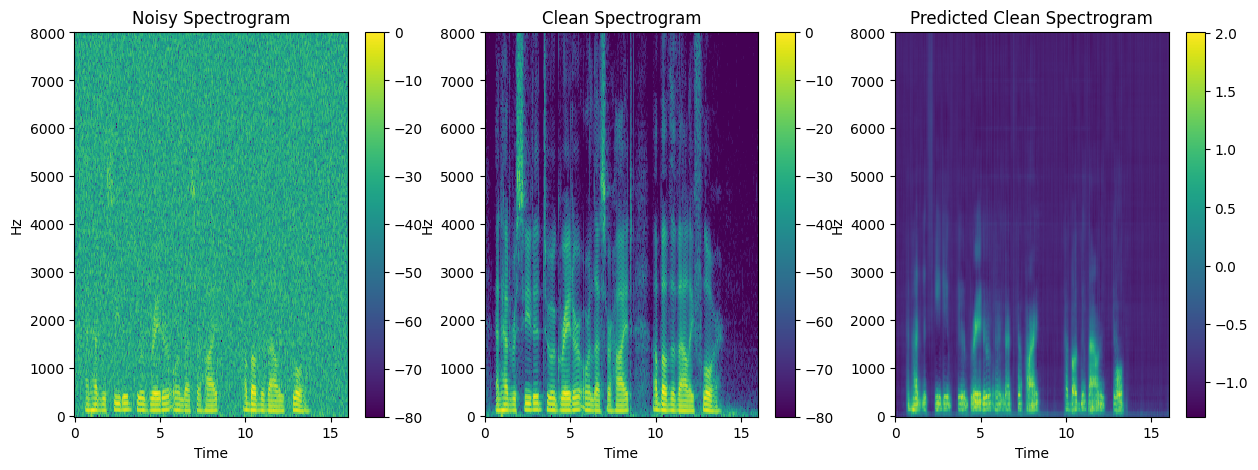

torch.Size([1, 257, 501])


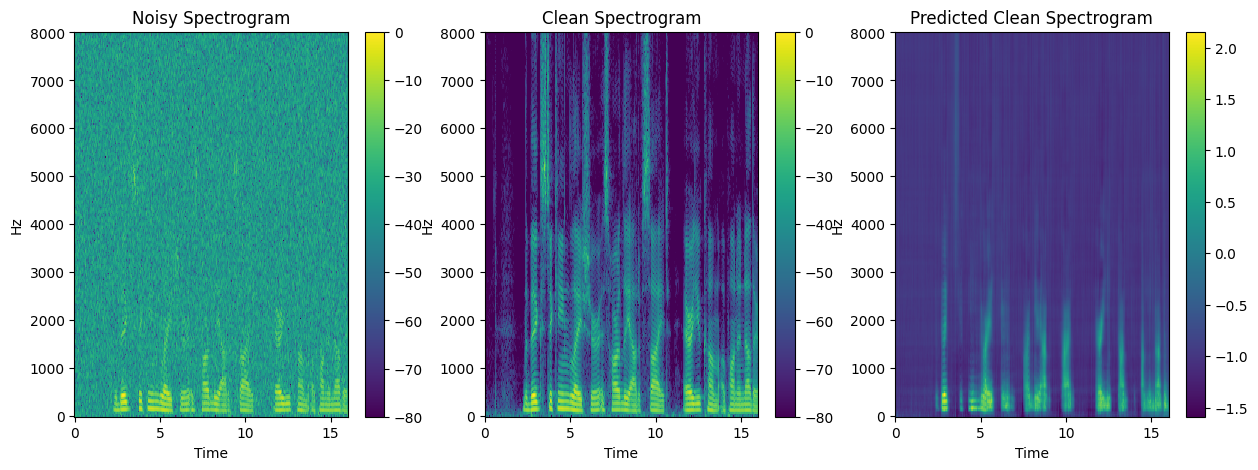

torch.Size([1, 257, 501])


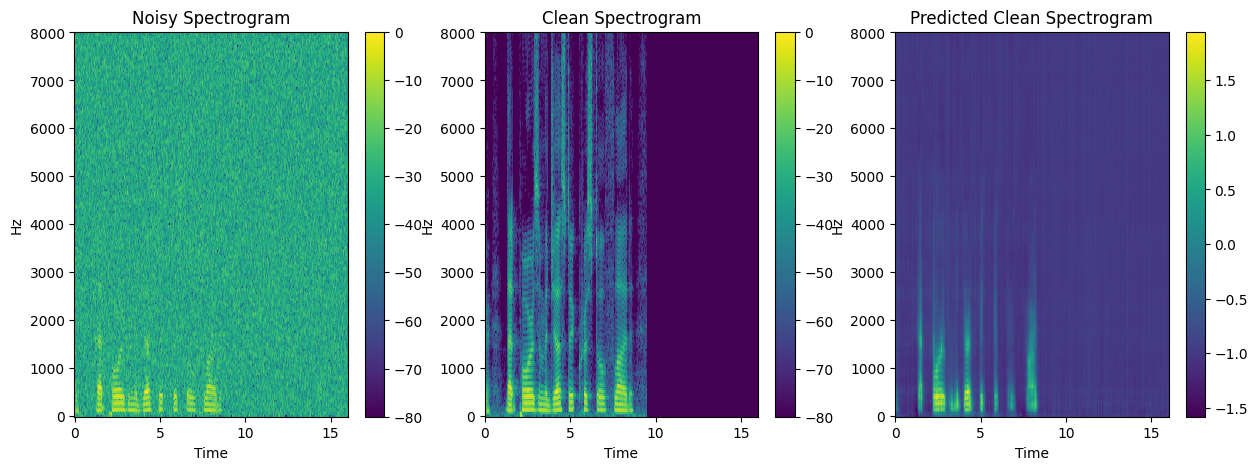

torch.Size([1, 257, 501])


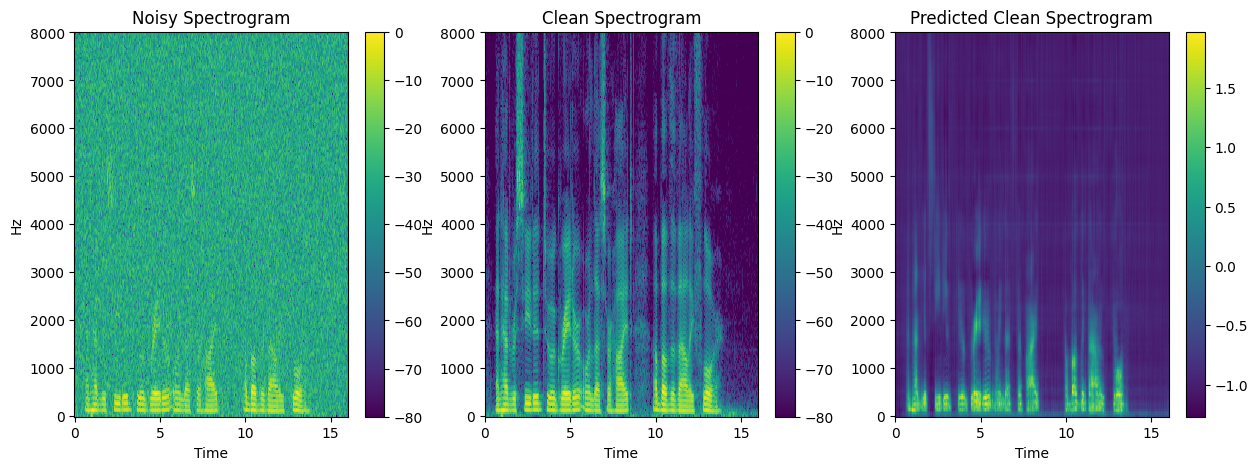

torch.Size([1, 257, 501])


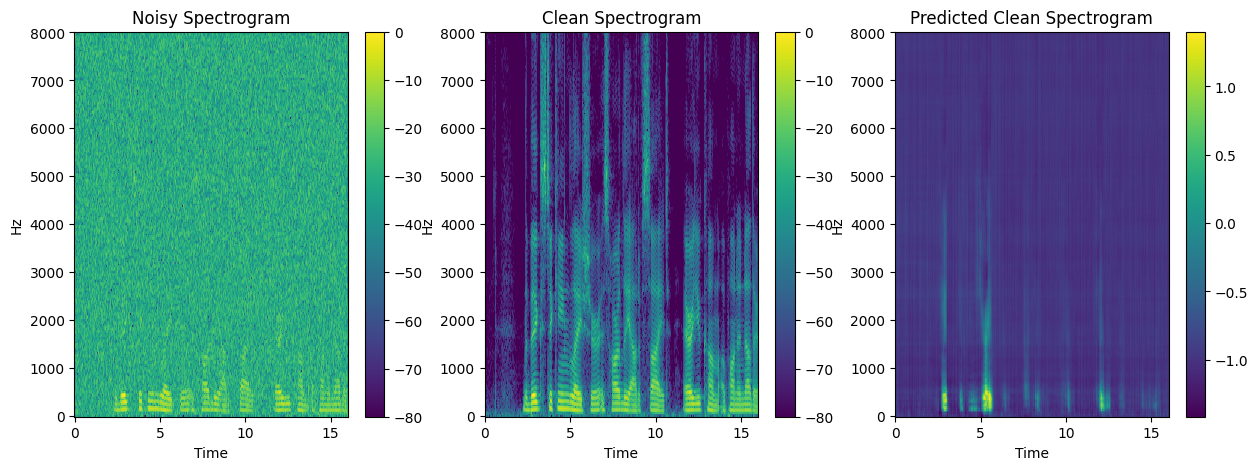

torch.Size([1, 257, 501])


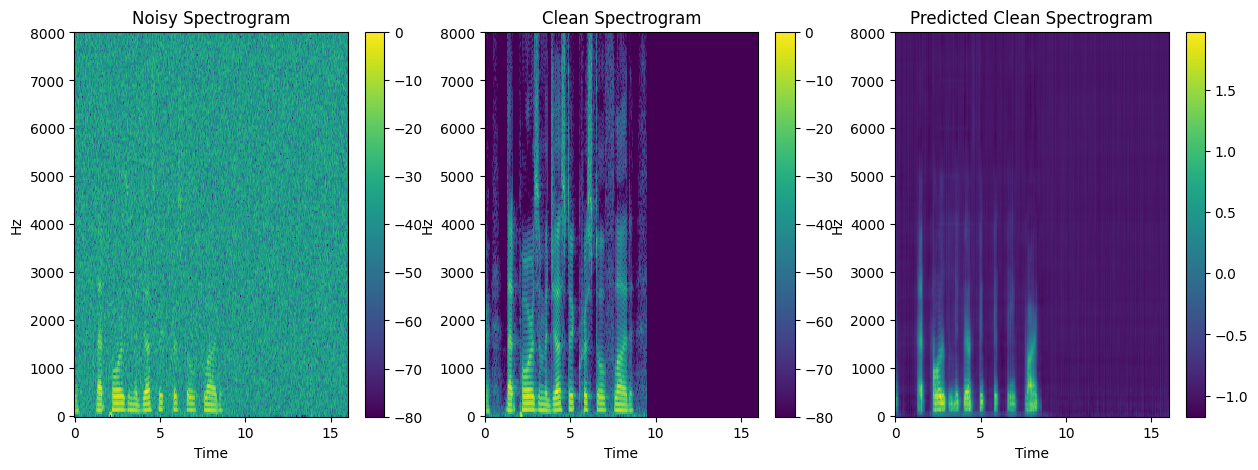

torch.Size([1, 257, 501])


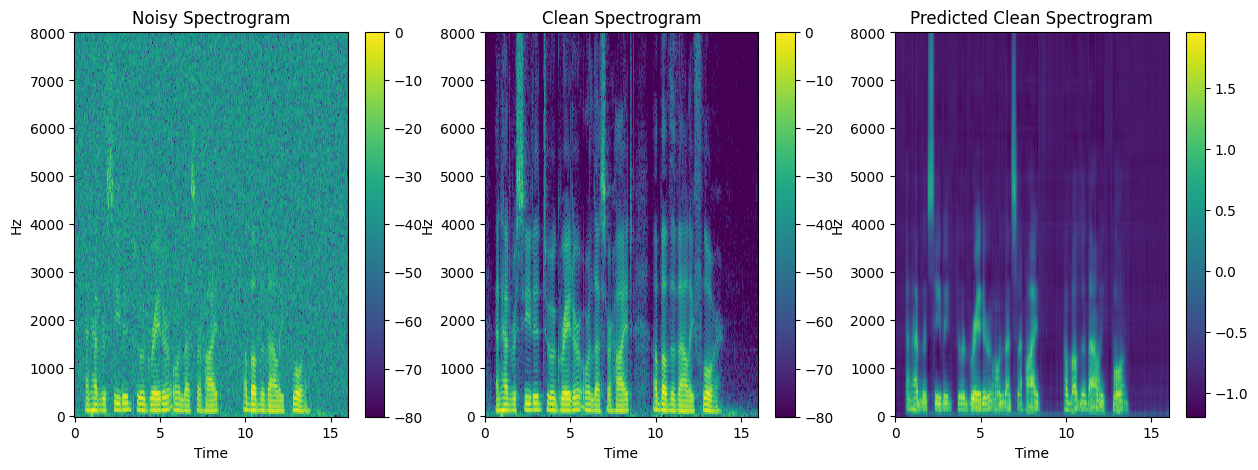

torch.Size([1, 257, 501])


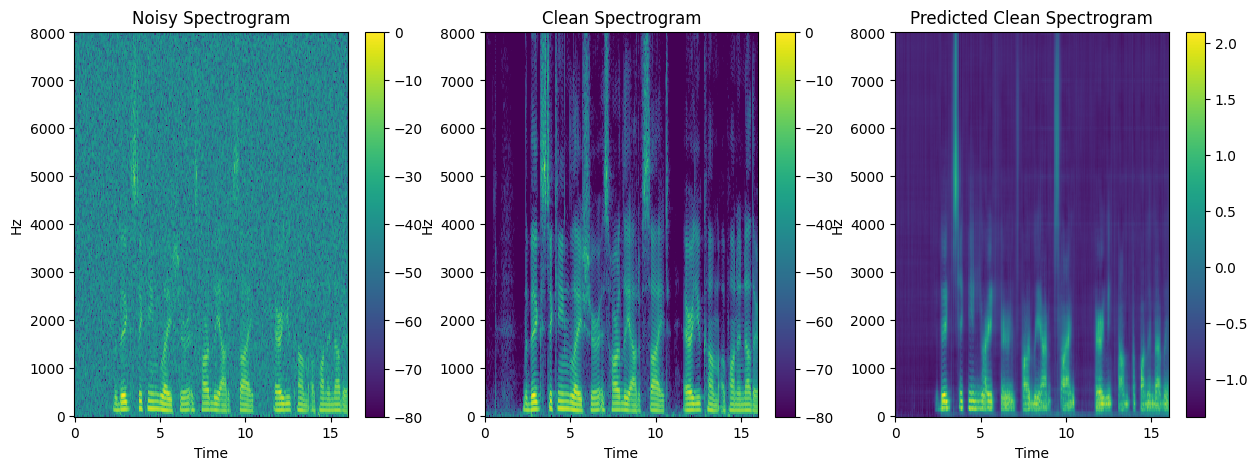

torch.Size([1, 257, 501])


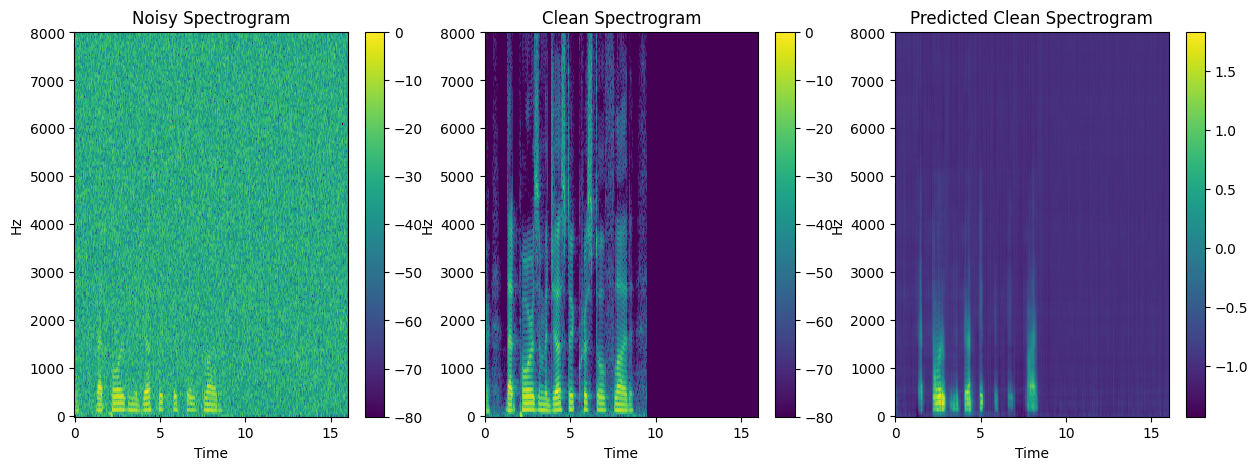

torch.Size([1, 257, 501])


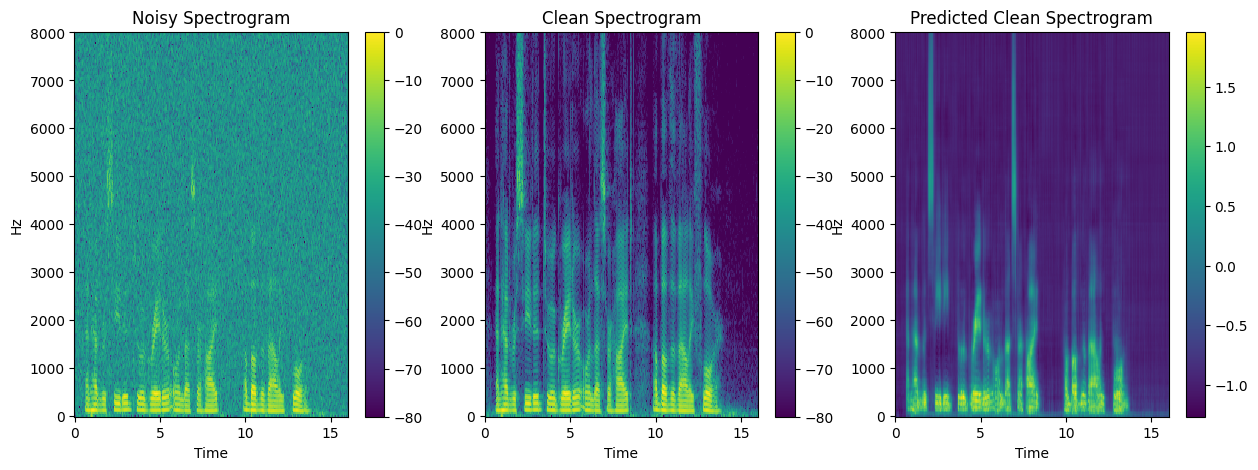

In [17]:
import librosa.display
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000 

display = True

for noisy_spectrogram, clean_spectrogram in test_audio_dataloader:

    print(noisy_spectrogram.shape)
    noisy_spectrogram = noisy_spectrogram.transpose(1, 2).to(device) 
    clean_spectrogram = clean_spectrogram.to(device)

    # Forward pass through the model
    with torch.no_grad():
        predicted_spectrogram = model(noisy_spectrogram)

    # Move back to CPU for visualization
    noisy_spectrogram = noisy_spectrogram.transpose(1, 2).cpu()
    clean_spectrogram = clean_spectrogram.cpu()
    predicted_spectrogram = predicted_spectrogram.transpose(1, 2).cpu()

    #snr_value = calculate_snr(clean_spectrogram, predicted_spectrogram)
    #print(f"SNR: {snr_value} dB")


    if(display):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        librosa.display.specshow(noisy_spectrogram[0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
        plt.colorbar()
        plt.title("Noisy Spectrogram")

        plt.subplot(1, 3, 2)
        librosa.display.specshow(clean_spectrogram[0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
        plt.colorbar()
        plt.title("Clean Spectrogram")

        plt.subplot(1, 3, 3)
        librosa.display.specshow(predicted_spectrogram[0].numpy(), sr=SAMPLE_RATE, x_axis="time", y_axis="hz", cmap="viridis")
        plt.colorbar()
        plt.title("Predicted Clean Spectrogram")

        plt.show()

igual introduzco demasiado ruido.
Calculo de SNR ratio mal seguro

In [16]:
# Convert predicted spectrogram back to waveform and save
import soundfile as sf

predicted_waveform = librosa.istft(predicted_spectrogram.squeeze().numpy(), hop_length=160, win_length=400)
sf.write("predicted_clean.wav", predicted_waveform, samplerate=SAMPLE_RATE)

MAMBA NET (error al instalar)

In [14]:
import torch
from mamba_ssm import Mamba

class Net2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # Linear layer to project input features to hidden space
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        
        # Mamba SSM layer for sequence modeling
        self.mamba = Mamba(
            d_model=hidden_size,  # Model dimension
            d_state=16,           # SSM state expansion factor
            d_conv=4,             # Local convolution width
            expand=2              # Block expansion factor
        )
        
        # Dropout for regularization
        self.drop = torch.nn.Dropout(0.1)
        
        # Final linear layer to project back to original frequency bins
        self.linear2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Input shape: (batch_size, freq_bins, time_steps)
        # Transpose to (batch_size, time_steps, freq_bins)
        #x = x.transpose(1, 2)
        
        # Linear transformation to hidden space
        x = self.linear1(x)
        
        # Mamba SSM for sequence modeling
        x = self.mamba(x)
        
        # Dropout for regularization
        x = self.drop(x)
        
        # Output projection to original frequency bins
        x = self.linear2(x)
        
        # Transpose back to (batch_size, freq_bins, time_steps)
        #x = x.transpose(1, 2)
        
        return x

"""
# Example usage
batch_size = 32
freq_bins = 257
time_steps = 501

input_size = freq_bins
hidden_size = 514  # Hidden size for Mamba layers
output_size = freq_bins  # Output should match the input spectrogram's frequency bins

model_mamba = Net2(input_size, hidden_size, output_size).cuda()

# Example input: Batch of noisy spectrograms
noisy_spectrogram = torch.randn(batch_size, freq_bins, time_steps).cuda()
cleaned_spectrogram = model_mamba(noisy_spectrogram)

print("Input shape:", noisy_spectrogram.shape)
print("Output shape:", cleaned_spectrogram.shape)

"""



'\n# Example usage\nbatch_size = 32\nfreq_bins = 257\ntime_steps = 501\n\ninput_size = freq_bins\nhidden_size = 514  # Hidden size for Mamba layers\noutput_size = freq_bins  # Output should match the input spectrogram\'s frequency bins\n\nmodel_mamba = Net2(input_size, hidden_size, output_size).cuda()\n\n# Example input: Batch of noisy spectrograms\nnoisy_spectrogram = torch.randn(batch_size, freq_bins, time_steps).cuda()\ncleaned_spectrogram = model_mamba(noisy_spectrogram)\n\nprint("Input shape:", noisy_spectrogram.shape)\nprint("Output shape:", cleaned_spectrogram.shape)\n\n'

In [ ]:
batch_size = 32
freq_bins = 257
time_steps = 501

input_size = freq_bins
hidden_size = 514  # Hidden size for Mamba layers
output_size = freq_bins  # Output should match the input spectrogram's frequency bins

model_mamba = Net2(input_size, hidden_size, output_size)

#Selecting cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train the model
train_model(model_mamba.to(device), audio_dataloader, num_epochs=10, learning_rate=0.001)

Using device: cuda


In [ ]:
# Define model parameters
input_size = 257  # For example, number of frequency bins in STFT (assuming 512 FFT size, 257 bins for half)
hidden_size = 512  # Hidden layer size
output_size = 257  # Output has the same size as input spectrogram (257 bins)
num_epochs = 40
learning_rate = 0.001
bidir_lstm = True
num_lstm_layers = 3

#Selecting cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
model = Net1(input_size, hidden_size, output_size, bidir_lstm, num_lstm_layers)

# Train the model
train_model(model_mamba.to(device), audio_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)

# Save weights of the model
torch.save(model.state_dict(), 'model_weights.pth')
